# Carregamento dos dados

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE

In [ ]:
df1 = pd.read_csv('State_of_data_2022.csv')
df1.shape

In [ ]:
df1.head()

# Pré-Processamento dos Dados

In [ ]:
df = df1.copy()

In [ ]:
# Fazendo um primeiro filtro de colunas do dataframe (fiz uma análise das colunas manualmente no excel pra essa primeira seleção)
df = df[["('P1_a ', 'Idade')","('P1_a_1 ', 'Faixa idade')","('P1_b ', 'Genero')","('P1_c ', 'Cor/raca/etnia')","('P1_d ', 'PCD')","('P1_g ', 'vive_no_brasil')",
           "('P1_i_1 ', 'uf onde mora')","('P1_i_2 ', 'Regiao onde mora')","('P1_l ', 'Nivel de Ensino')","('P1_m ', 'Área de Formação')",
           "('P2_a ', 'Qual sua situação atual de trabalho?')","('P2_b ', 'Setor')","('P2_c ', 'Numero de Funcionarios')","('P2_d ', 'Gestor?')","('P2_f ', 'Cargo Atual')",
           "('P2_g ', 'Nivel')","('P2_h ', 'Faixa salarial')","('P2_i ', 'Quanto tempo de experiência na área de dados você tem?')",
           "('P2_j ', 'Quanto tempo de experiência na área de TI/Engenharia de Software você teve antes de começar a trabalhar na área de dados?')",
           "('P2_k ', 'Você está satisfeito na sua empresa atual?')","('P2_m ', 'Você participou de entrevistas de emprego nos últimos 6 meses?')",
           "('P2_n ', 'Você pretende mudar de emprego nos próximos 6 meses?')","('P2_p ', 'Atualmente qual a sua forma de trabalho?')",
           "('P2_s ', 'Sua empresa passu por Layoff em 2022?')","('P3_a ', 'Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje?')",
           "('P4_a_1 ', 'Atuacao')","('P4_d ', 'Quais das linguagens listadas abaixo você utiliza no trabalho?')","('P4_d_1 ', 'SQL')","('P4_d_2 ', 'R ')",
           "('P4_d_3 ', 'Python')","('P4_d_4 ', 'C/C++/C#')","('P4_d_5 ', '.NET')","('P4_d_6 ', 'Java')","('P4_d_7 ', 'Julia')","('P4_d_8 ', 'SAS/Stata')",
           "('P4_d_9 ', 'Visual Basic/VBA')","('P4_d_10 ', 'Scala')","('P4_d_11 ', 'Matlab')","('P4_d_12 ', 'PHP')","('P4_d_13 ', 'Javascript')",
           "('P4_d_14 ', 'Não utilizo nenhuma linguagem')","('P5_c ', 'Há quanto tempo você busca uma oportunidade na área de dados?')",
]]

In [ ]:
df.info()

In [ ]:
# Renomeando as colunas
# Função para extrair o nome da coluna dos títulos
def extract_column_name(title):
    return title.split(", ")[1][1:-2]

# Renomear as colunas
df.columns = [extract_column_name(title) for title in df.columns]

In [ ]:
df.columns

In [ ]:
# Renomeando a coluna 'target' e colocando-a na posição 1
df.rename(columns={"Faixa salarial":'target'}, inplace = True)
target = df.pop("target")
df.insert(0,'target', target)
df.head()

In [ ]:
df.isna().sum()

In [ ]:
# Visualização dos valores missings 
msno.bar(df, sort="descending", figsize=(10,6), fontsize=8).grid()

Inicialmente vou remover os registros que temos NA na coluna target.  
Em seguida vou remover colunas que têm muitos valores NA que vão acabar tirando grande parte da nossa amostra. 

In [ ]:
# Removendo valores de target = NA
df_filtered = df.dropna(subset=['target'])
df_filtered.isna().sum()

In [ ]:
# Visualização dos NA
msno.bar(df_filtered, sort="descending", figsize=(10,6), fontsize=8).grid()

In [ ]:
# Visualização onde temos Nível = NA
df_filtered[(df_filtered['Nivel'].isna())].iloc[:,5:20].sample(10)

In [ ]:
# é possível verificar que todos os valores onde temos 'Cargo Atual' e 'Nivel' como NA, são cargos de Gestor, ou seja, não precisamos da coluna Gestor. Podemos imputar 'Gestor' na coluna 'Cargo Atual' e 'Nivel' para todos os NA e remover a coluna 'Gestor?'
df_filtered[(df_filtered['Cargo Atual'].isna())]['Gestor?'].value_counts()

In [ ]:
# Valores da coluna gestor pra onde temos Nivel NA
df_filtered[(df_filtered['Nivel'].isna())]['Gestor?'].value_counts()

In [ ]:
# Valores da coluna gestor pra onde temos Cargo Atual NOT NA
df_filtered[(df_filtered['Cargo Atual'].isna() == False)]['Gestor?'].value_counts()

In [ ]:
# Valores da coluna gestor pra onde temos Nivel NOT NA
df_filtered[(df_filtered['Nivel'].isna() == False)]['Gestor?'].value_counts()

In [ ]:
# Valores da coluna Cargo ATual
df_filtered[(df_filtered['Cargo Atual'].isna() == False)]['Cargo Atual'].value_counts()

In [ ]:
# Removendo coluna 'Gestor?' e preenchendo os NA com "Gestor" nas colunas 'Nivel' e 'Cargo Atual'
df_filtered2 = df_filtered.copy()
df_filtered2 = df_filtered2.drop(columns=['Gestor?'])
df_filtered2[['Nivel','Cargo Atual']] = df_filtered[['Nivel','Cargo Atual']].fillna('Gestor')
df_filtered2.isna().sum()

Vou remover as colunas 'Idade', pois esta apresenta valores NA além de também ja termos a coluna de faixa etária.  
Também irei remover as colunas que possuem MUITOS valores NA como 'Há quanto tempo você busca uma oportunidade na área de dados?' e 'Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje?'.  
Ainda a decidir se irei remover as colunas das linguagens utilizadas no trabalho

In [ ]:
df_filtered2 = df_filtered2.drop(columns=["Qual o número aproximado de pessoas que atuam com dados na sua empresa hoje?","Há quanto tempo você busca uma oportunidade na área de dados?", "Idade"])
df_filtered2.isna().sum()

In [ ]:
# Checando a relação das colunas 'vive_no_brasil' com 'uf onde mora' e 'Regiao onde mora'
# valores de 'vive_no_brasil' quando temos Regiao onde mora NA
df_filtered2[(df_filtered2['Regiao onde mora'].isna())]['vive_no_brasil'].value_counts()

In [ ]:
# valores de 'vive_no_brasil' quando temos Regiao onde mora not NA
df_filtered2[(df_filtered2['Regiao onde mora'].isna() == False)]['vive_no_brasil'].value_counts()

Novamente, aqui irei remover a coluna vive_no_brasil e preencher os valores de NA da coluna 'Regiao onde mora' com 'Exterior'. Também irei remover a coluna 'uf onde mora' e manter apenas a 'Regiao onde mora'

In [ ]:
df_filtered2 = df_filtered2.drop(columns=['vive_no_brasil', 'uf onde mora'])
df_filtered2['Regiao onde mora'] = df_filtered2['Regiao onde mora'].fillna('Exterior')
df_filtered2.isna().sum()

In [ ]:
# Visualizando onde temos valores de Genero NA.
# Tenhos três opções: preencher com 'Prefiro não informar', preencher aleatóriamente com base nos valores que temos ou remover esses registros. 
# Vou decidir por dropar os NA da coluna Genero"Prefiro não informar" 
# Vale repensar/testar se vale a pena remover esses juntos com os "Prefiro não informar"
df_filtered2[(df_filtered2['Genero'].isna())]

In [ ]:
df_filtered2['Genero'].value_counts()

In [ ]:
df_filtered3 = df_filtered2.copy()
df_filtered3 = df_filtered3.dropna(subset=['Genero'])
df_filtered3.isna().sum()

In [ ]:
# Checando valores da coluna 'Área de Formação'
df_filtered3[(df_filtered3['Área de Formação'].isna())]

In [ ]:
# Confirmando que todos os valores de Área de formação NA são pessoal que nao tem graduação formal
df_filtered3[(df_filtered3['Área de Formação'].isna())]['Nivel de Ensino'].value_counts()

In [ ]:
# Atribuindo 'Sem Formação Formal' para os valores NA que têm 'Nivel de Ensino' com valor = 'Não tenho graduação formal'.  Irei remover os NA restante logo em seguida

#df_filtered3[((df_filtered3['Área de Formação'].isna()) & (df_filtered3['Nivel de Ensino'] == 'Não tenho graduação formal'))]['Área de Formação'] = 'Sem Formação Formal' --> errado

df_filtered3.loc[(df_filtered3['Área de Formação'].isna()) & (df_filtered3['Nivel de Ensino'] == 'Não tenho graduação formal'), 'Área de Formação'] = 'Sem Formação Formal'
df_filtered3 = df_filtered3.dropna(subset=['Área de Formação'])


In [ ]:
df_filtered3.isna().sum()

Agora vou remover a pergunta das linguagens utilizadas devido ao grande numero de NA

In [ ]:
df_filtered3 = df_filtered3.iloc[:, :-15]
df_filtered3.isna().sum()

In [ ]:
df_filtered3.shape

In [ ]:
# Checando valores da coluna 'Qual sua situação atual de trabalho?'
df_filtered3['Área de Formação'].value_counts()

In [ ]:
# Visualizando os valores de todas as variáveis
colunas = df_filtered3.columns
for i in colunas:
    print(i)
    print(df_filtered3[f'{i}'].value_counts())

# Análise Exploratória

In [ ]:
df_filtered3.target.hist(grid = True, xrot = 90)

# Pré-Processamento dos Dados - pt2

Como todas as variáveis que estão sendo usadas são categóricas, teremos que aplicar as técnicas de Label Encoding e One Hot Encoding

In [ ]:
df_filtered3['Atuacao'].value_counts()

In [ ]:
# Separando colunas
cols_encod = ['target', 'Faixa idade','Nivel de Ensino','Nivel','Numero de Funcionarios','Quanto tempo de experiência na área de dados você tem?',
              'Quanto tempo de experiência na área de TI/Engenharia de Software você teve antes de começar a trabalhar na área de dados?']
cols_one_hot = ['Genero','Cor/raca/etnia', 'PCD','Regiao onde mora','Área de Formação','Qual sua situação atual de trabalho?', 'Setor',
                'Cargo Atual','Você participou de entrevistas de emprego nos últimos 6 meses?','Você pretende mudar de emprego nos próximos 6 meses?',
                'Atualmente qual a sua forma de trabalho?','Sua empresa passu por Layoff em 2022?','Atuacao']
col_binarias = ['Você está satisfeito na sua empresa atual?']

In [ ]:
# Encoding

faixa_salario_map = {
    'Menos de R$ 1.000/mês':0,
    'de R$ 1.001/mês a R$ 2.000/mês':1,
    'de R$ 2.001/mês a R$ 3.000/mês':2,
    'de R$ 3.001/mês a R$ 4.000/mês':3,
    'de R$ 4.001/mês a R$ 6.000/mês':4,
    'de R$ 6.001/mês a R$ 8.000/mês':5,
    'de R$ 8.001/mês a R$ 12.000/mês':6,
    'de R$ 12.001/mês a R$ 16.000/mês':7,
    'de R$ 16.001/mês a R$ 20.000/mês':8,
    'de R$ 20.001/mês a R$ 25.000/mês':9,
    'de R$ 25.001/mês a R$ 30.000/mês':10,
    'de R$ 30.001/mês a R$ 40.000/mês':11,
    'Acima de R$ 40.001/mês':12
                     }

faixa_etaria_map ={
    '17-21':0,
    '22-24':1,
    '25-29':2,
    '30-34':3,
    '35-39':4,    
    '40-44':5,
    '45-49':6,    
    '50-54':7,
    '55+':8 
}

nivel_ensino_map = {
    'Não tenho graduação formal':0,
    'Estudante de Graduação':1,
    'Graduação/Bacharelado':2,
    'Pós-graduação':3,    
    'Mestrado':4,
    'Doutorado ou Phd':5,    
}

nivel_map = {
    "Júnior":0,
    "Pleno":1,
    "Sênior":2,
    "Gestor":3    
}

num_funcionario_map = {
    'de 1 a 5':0,
    'de 6 a 10':1,
    'de 11 a 50':2,
    'de 51 a 100':3,
    'de 101 a 500':4,
    'de 501 a 1.000':5,
    'de 1.001 a 3.000':6,
    'Acima de 3.000':7
}

tempo_exp_map = {
    'Não tenho experiência na área de dados':0,
    'Menos de 1 ano':1,
    'de 1 a 2 anos':2,
    'de 3 a 4 anos':3,
    'de 4 a 6 anos':4,
    'de 7 a 10 anos':5,
    'Mais de 10 anos':6
}

tempo_exp_ti_map = {
    'Não tive experiência na área de TI/Engenharia de Software antes de começar a trabalhar na área de dados':0,
    'Menos de 1 ano':1,
    'de 1 a 2 anos':2,
    'de 3 a 4 anos':3,
    'de 5 a 6 anos':4,
    'de 7 a 10 anos':5,
    'Mais de 10 anos':6
}

# Lista com dicionários para aplicar no meu df
dictss = [faixa_salario_map,faixa_etaria_map,nivel_ensino_map,nivel_map,num_funcionario_map,tempo_exp_map,tempo_exp_ti_map]

> df_encoded vai conter os pre processamento de label encoding e one_hot encoding

In [ ]:
df_encoded = df_filtered3.copy()

In [ ]:
# Aplicando o Label Enconding
for i in range(0,len(cols_encod)):
    df_encoded[cols_encod[i]] = df_encoded[cols_encod[i]].map(dictss[i])

In [ ]:
# Aplicando o One hot Encoding
def one_hot_encoding(df, cols):
    """
    Realiza one-hot encoding.
    
    Parâmetros:
        df (DataFrame): DataFrame contendo as variáveis categóricas.
        cols (list): Lista das colunas a serem codificadas em one-hot encoding.
        
    Retorna:
        DataFrame: O DataFrame com as colunas especificadas codificadas em one-hot encoding.
    """
    return pd.get_dummies(df, columns=cols)



In [ ]:
df_encoded = one_hot_encoding(df = df_encoded, cols = cols_one_hot)
df_encoded.head()

In [ ]:
# Aplicando 0 e 1 pra vairáveis booleana 'Você está satisfeito na sua empresa atual?'
df_encoded['Você está satisfeito na sua empresa atual?'] = df_encoded['Você está satisfeito na sua empresa atual?'].map({True: 1, False: 0})
df_encoded.head()

# Machine Learning

In [ ]:
# Copia do df pre processado
df_ml = df_encoded.copy()

X = df_ml.drop('target',axis=1)
y = df_ml['target']

- Random Forest (RF)
- Modelo de Regressão Logistico Multinomial
- Gradient Boosting Machines (GBM)
- Redes Neurais Artificiais (NN)
- Support Vector Machines (SVM)

In [ ]:
# Fuunção para separar a coluna target das preditoras e separar em amostra de treino e teste
def split_data(df, target_column, test_size=0.25, random_state=19):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    return X_train, X_test, y_train, y_test   


In [ ]:
# Atribuindo os dados de treino e teste
X_train, X_test, y_train, y_test = split_data(df= df_ml, target_column='target', test_size=0.25, random_state=19)

### Funções

In [ ]:
# Função para rodar modelo de Random Forest tunando os hiper parametros com o GridSearch

def ML_RandomForest(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1):
    
    """Função para rodar nossos dados de treino e teste em um modelo de Random Forest"""
    
    # Buscando os melhores hiperparametros com o GridSearch
    param_grid = {
        'n_estimators': [100, 200, 300],  # Número de árvores na floresta
        'max_depth': [None, 10, 20],        # Profundidade máxima de cada árvore
        'min_samples_split': [2, 5, 10],    # O número mínimo de amostras necessárias para dividir um nó interno
        'min_samples_leaf': [1, 2, 4]      # O número mínimo de amostras necessárias para estar em um nó folha
    }

    # Inicialize o modelo Random Forest
    random_forest = RandomForestClassifier(random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring = scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado
    y_pred = grid_search.predict(X_test) 

    # Avalie o desempenho do modelo otimizado
    accuracy_rf_optimized = accuracy_score(y_test, y_pred)
    f1_rf_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_rf_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_rf_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_rf_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_rf_optimized)
    print("F1-Score:", f1_rf_optimized)
    print("Precisão:", precision_rf_optimized)
    print("Revocação:", recall_rf_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_rf_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return y_pred       

In [ ]:
# Função para rodar modelo Logistico Mltinomial tunando os hiper parametros com o GridSearch

def ML_LogMult(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
        'max_iter': [100, 200, 300]  # Número máximo de iterações
    }

    # Inicialize o modelo de regressão logística multinomial
    logistic_model = LogisticRegression(multi_class='multinomial', random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Avalie o desempenho do modelo otimizado
    accuracy_lm_optimized = accuracy_score(y_test, y_pred)
    f1_lm_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_lm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_lm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_lm_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_lm_optimized)
    print("F1-Score:", f1_lm_optimized)
    print("Precisão:", precision_lm_optimized)
    print("Revocação:", recall_lm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_lm_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return y_pred       

In [ ]:
# Função para rodar modelo Logistico XGBoost tunando os hiper parametros com o GridSearch

def ML_Xgboost(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1 ):
    
    """return y_pred"""
    num_class = len(y_train.value_counts())
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_class)

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'n_estimators': [100, 200, 300],  
        'max_depth': [3, 4, 5],        
        'learning_rate': [0.01, 0.1, 0.2]  
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs = n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_xgb_optimized = accuracy_score(y_test, y_pred)
    f1_xgb_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_xgb_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_xgb_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_xgb_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_xgb_optimized}')
    print(f'F1-score LXGBoost: {f1_xgb_optimized}')
    print("Precisão:", precision_xgb_optimized)
    print("Revocação:", recall_xgb_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_xgb_optimized)
    
    return y_pred

In [ ]:
# Função para rodar modelo Logistico SVM tunando os hiper parametros com o GridSearch

def ML_Svm(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1):
    svm_model = SVC()

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'C': [0.1, 1, 10],  
        'kernel': ['linear', 'rbf', 'poly'],        
        'gamma': ['scale', 'auto']
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_svm_optimized = accuracy_score(y_test, y_pred)
    f1_svm_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_svm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_svm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_svm_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_svm_optimized}')
    print(f'F1-score LXGBoost: {f1_svm_optimized}')
    print("Precisão:", precision_svm_optimized)
    print("Revocação:", recall_svm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_svm_optimized)
    
    return y_pred
    

### SMOTE

Como temos uma variável Y desbalanceada, pode ser que a aplicação do SMOTE(que balanceia os valores da variável) ajude.

0      34
1     213
2     280
3     300
4     582
5     527
6     751
7     437
8     228
9     134
10     77
11     70
12     45
Name: target, dtype: int64


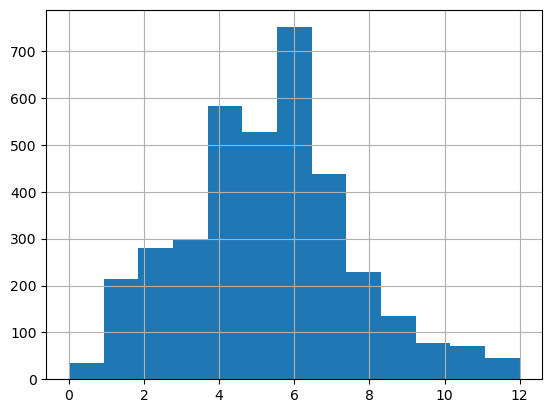

In [135]:
df_ml['target'].hist(bins = len(df_ml['target'].value_counts()))
print(df_ml['target'].value_counts().sort_index())

Distribuição das classes após SMOTE:
0     567
1     567
2     567
3     567
4     567
5     567
6     567
7     567
8     567
9     567
10    567
11    567
12    567
Name: target, dtype: int64


<AxesSubplot:>

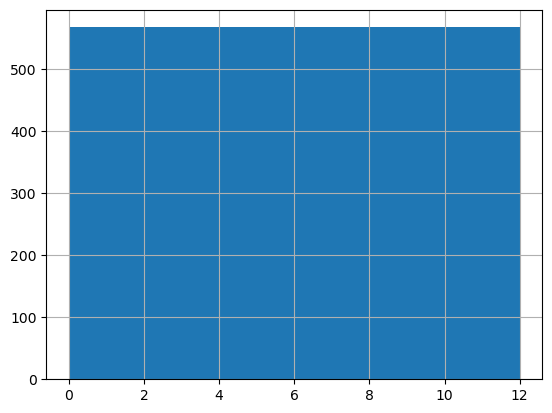

In [136]:
# Inicialize o SMOTE
smote = SMOTE(random_state=19)

# Aplique o SMOTE ao conjunto de treinamento (X_train e y_train)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Verifique a distribuição das classes após a aplicação do SMOTE
print("Distribuição das classes após SMOTE:")
print(pd.Series(y_train_resampled).value_counts().sort_index())
y_train_resampled.hist(bins = 13)

## Random Forest

In [ ]:
# # Inicializando o modelo
# random_forest = RandomForestClassifier(n_estimators=100, random_state=19)

# # Treinando o modelo
# random_forest.fit(X_train, y_train)

# # Fazendo previsões no conjunto de teste
# y_pred = random_forest.predict(X_test)

# # Avalie a precisão do modelo
# accuracy_rf = accuracy_score(y_test, y_pred)
# f1_rf = f1_score(y_test, y_pred, average='weighted')
# print("Accuracy:", accuracy_rf)
# print('f1-score:', f1_rf)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))


In [ ]:
# # Buscando os melhores hiperparametros com o GridSearch
# param_grid = {
#     'n_estimators': [100, 200, 300],  # Número de árvores na floresta
#     'max_depth': [None, 10, 20],        # Profundidade máxima de cada árvore
#     'min_samples_split': [2, 5, 10],    # O número mínimo de amostras necessárias para dividir um nó interno
#     'min_samples_leaf': [1, 2, 4]      # O número mínimo de amostras necessárias para estar em um nó folha
# }

# # Inicialize o modelo Random Forest
# random_forest = RandomForestClassifier(random_state=19)

# # Inicialize o objeto GridSearchCV
# grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# # Realize o ajuste aos dados de treinamento
# grid_search.fit(X_train, y_train)

# # Imprima os melhores parâmetros encontrados
# print("Melhores parâmetros:", grid_search.best_params_)

# # Faça previsões com o modelo otimizado
# y_pred = grid_search.predict(X_test)

# # Avalie o desempenho do modelo otimizado
# accuracy_rf_optimized = accuracy_score(y_test, y_pred)
# f1_rf_optimized = f1_score(y_test, y_pred, average='weighted')
# precision_rf_optimized = precision_score(y_test, y_pred, average='weighted')
# recall_rf_optimized = recall_score(y_test, y_pred, average='weighted')
# conf_matrix_rf_optimized = confusion_matrix(y_test, y_pred)
# print("Accuracy:", accuracy_rf_optimized)
# print("F1-Score:", f1_rf_optimized)
# print("Precisão:", precision_rf_optimized)
# print("Revocação:", recall_rf_optimized)
# print("Matriz de Confusão:")
# print(conf_matrix_rf_optimized)

# # Exiba o relatório de classificação
# print(classification_report(y_test, y_pred))


> Como temos uma variável target um pouco desbalanceada, tentarei aplicar o SMOTE para verificar se melhor o modelo

In [ ]:
# df_ml['target'].hist(bins=13)
# print(df_ml['target'].value_counts().sort_index())

In [ ]:
# # Inicialize o SMOTE
# smote = SMOTE(random_state=19)

# # Aplique o SMOTE ao conjunto de treinamento (X_train e y_train)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# # Verifique a distribuição das classes após a aplicação do SMOTE
# print("Distribuição das classes após SMOTE:")
# print(pd.Series(y_train_resampled).value_counts().sort_index())
# y_train_resampled.hist(bins = 13)

In [ ]:
# Buscando os melhores hiperparametros com o GridSearch para os dados de treino com SMOTE aplicado
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árvores na floresta
    'max_depth': [None, 10, 20],        # Profundidade máxima de cada árvore
    'min_samples_split': [2, 5, 10],    # O número mínimo de amostras necessárias para dividir um nó interno
    'min_samples_leaf': [1, 2, 4]       # O número mínimo de amostras necessárias para estar em um nó folha
}

# Inicialize o objeto GridSearchCV
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='f1', n_jobs=1)

# Realize o ajuste aos dados de treinamento resampleados
grid_search.fit(X_train_resampled, y_train_resampled)

# Imprima os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Faça previsões com o modelo otimizado usando o conjunto de teste
y_pred = grid_search.predict(X_test)

# Avalie o desempenho do modelo otimizado
accuracy_rf_smote = accuracy_score(y_test, y_pred)
f1_rf_smote = f1_score(y_test, y_pred, average='weighted')
#auc_roc = roc_auc_score(y_test, y_pred)
precision_rf_smote = precision_score(y_test, y_pred, average='weighted')
recall_rf_smote = recall_score(y_test, y_pred, average='weighted')
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred)
print("Accuracy:", accuracy_rf_smote)
print("F1-Score:", f1_rf_smote)
#print("AUC-ROC:", auc_roc)
print("Precisão:", precision_rf_smote)
print("Revocação:", recall_rf_smote)
print("Matriz de Confusão:")
print(conf_matrix_rf_smote)


# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))


> Tivemos uma redução na acurácia do modelo. Portanto nesse caso o modelo ficar melhor sem o uso da técnica de SMOTE

## Modelo de Regressão Logistico Multinomial

In [ ]:
# Inicialize e ajuste o modelo de regressão logística multinomial
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_model.fit(X_train, y_train)

# Faça previsões com o modelo
y_pred = logistic_model.predict(X_test)

# Avaliando o desempenho
accuracy_rlm = accuracy_score(y_test, y_pred)
f1_rlm = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy_rlm)
print("F1-Score:", f1_rlm)

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))

In [ ]:
# Tunning dos hiperparâmetros com GridSearch
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
    'max_iter': [100, 200, 300]  # Número máximo de iterações
}

# Inicialize o modelo de regressão logística multinomial
logistic_model = LogisticRegression(multi_class='multinomial')

# Inicialize o objeto GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Realize o ajuste aos dados de treinamento
grid_search.fit(X_train, y_train)

# Imprima os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Faça previsões com o modelo otimizado usando o conjunto de teste
y_pred = grid_search.predict(X_test)

# Avaliando o desempenho
accuracy_rlm_optimized = accuracy_score(y_test, y_pred)
f1_rlm_optimized = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy_rlm_optimized)
print("F1-Score:", f1_rlm_optimized)

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))

In [ ]:
# Tunning dos hiperparâmetros com GridSearch para os dados com SMOTE
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
    'max_iter': [100, 200, 300]  # Número máximo de iterações
}

# Inicialize o modelo de regressão logística multinomial
logistic_model = LogisticRegression(multi_class='multinomial')

# Inicialize o objeto GridSearchCV
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Realize o ajuste aos dados de treinamento
grid_search.fit(X_train_resampled, y_train_resampled)

# Imprima os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Faça previsões com o modelo otimizado usando o conjunto de teste
y_pred = grid_search.predict(X_test)

# Avalie o desempenho do modelo otimizado
f1_score_optimized = f1_score(y_test, y_pred, average='weighted')
print("F1-Score do modelo otimizado:", f1_score_optimized)


accuracy_rlm_optimized_smote = accuracy_score(y_test, y_pred)
f1_rlm_optimized_smote = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy_rlm_optimized_smote)
print("F1-Score:", f1_rlm_optimized_smote)

## Gradient Boosting Machines

In [ ]:
# Inicialize o modelo GBM XGBoost
xgboost_model = xgb.XGBClassifier(objective='multi:softmax', num_class=13)

# Treine o modelo GBM XGBoost
xgboost_model.fit(X_train, y_train)

# Faça previsões com o modelo
y_pred = xgboost_model.predict(X_test)

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))
accuracy_xgb = accuracy_score(y_test, y_pred)
f1_xgb = f1_score(y_test, y_pred,average='weighted')
print(f'Acuracia XGBoost: {accuracy_xgb}')
print(f'F1-score LXGBoost: {f1_xgb}')

In [ ]:
# Inicialize o modelo GBM XGBoost
model = xgb.XGBClassifier(objective='multi:softmax', num_class=13)

# Defina os hiperparâmetros que deseja ajustar
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5],        
    'learning_rate': [0.01, 0.1, 0.2]  
}

# Inicialize o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Realize o ajuste aos dados de treinamento
grid_search.fit(X_train, y_train)

# Imprima os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Faça previsões com o modelo otimizado usando o conjunto de teste
y_pred = grid_search.predict(X_test)

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))
accuracy_xgb_optimized = accuracy_score(y_test, y_pred)
f1_xgb_optimized = f1_score(y_test, y_pred,average='weighted')
print(f'Acuracia XGBoost: {accuracy_xgb_optimized}')
print(f'F1-score LXGBoost: {f1_xgb_optimized}')

In [ ]:
# Modelo com melhores hiperparametros para o dataset com SMOTE --> ficou pior
model = xgb.XGBClassifier(objective='multi:softmax', num_class=13)

# Defina os hiperparâmetros que deseja ajustar
param_grid = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [3, 4, 5],        
    'learning_rate': [0.01, 0.1, 0.2]  
}

# Inicialize o objeto GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Realize o ajuste aos dados de treinamento
grid_search.fit(X_train_resampled, y_train_resampled)

# Imprima os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Faça previsões com o modelo otimizado usando o conjunto de teste
y_pred = grid_search.predict(X_test)

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))
accuracy_xgb_optimized_smote = accuracy_score(y_test, y_pred)
f1_xgb_optimized_smote = f1_score(y_test, y_pred,average='weighted')
print(f'Acuracia XGBoost: {accuracy_xgb_optimized_smote}')
print(f'F1-score LXGBoost: {f1_xgb_optimized_smote}')

## Redes Neurais Artificiais

## Support Vector Machine (SVM)

In [ ]:
# Inicialize o modelo SVM com o esquema OvR
svm_model = SVC(kernel='linear', decision_function_shape='ovr')

# Treine o modelo SVM
svm_model.fit(X_train, y_train)

# Faça previsões com o modelo
y_pred = svm_model.predict(X_test)

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))
accuracy_svm = accuracy_score(y_test, y_pred)
f1_svm = f1_score(y_test, y_pred,average='weighted')
print(f'Acuracia XGBoost: {accuracy_svm}')
print(f'F1-score LXGBoost: {f1_svm}')

In [ ]:
# Inicialize o modelo SVM
svm_model = SVC()

# Defina os hiperparâmetros que deseja ajustar
param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf', 'poly'],        
    'gamma': ['scale', 'auto']
}

# Inicialize o objeto GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# Realize o ajuste aos dados de treinamento
grid_search.fit(X_train, y_train)

# Imprima os melhores parâmetros encontrados
print("Melhores parâmetros:", grid_search.best_params_)

# Faça previsões com o modelo otimizado usando o conjunto de teste
y_pred = grid_search.predict(X_test)

# Exiba o relatório de classificação
print(classification_report(y_test, y_pred))
accuracy_svm_optimized = accuracy_score(y_test, y_pred)
f1_svm_optimized = f1_score(y_test, y_pred,average='weighted')
print(f'Acuracia XGBoost: {accuracy_svm_optimized}')
print(f'F1-score LXGBoost: {f1_svm_optimized}')


Acurácia (Accuracy): A acurácia é a proporção de exemplos classificados corretamente pelo modelo em relação ao total de exemplos. É uma métrica simples e fácil de interpretar, mas pode ser enganosa em casos de classes desbalanceadas.

AUC-ROC: A área sob a curva ROC (Receiver Operating Characteristic) é uma métrica que avalia a capacidade do modelo de distinguir entre as classes positiva e negativa. Uma pontuação AUC-ROC de 1.0 indica um modelo perfeito, enquanto uma pontuação de 0.5 indica um modelo que não é melhor do que o acaso. A AUC-ROC é útil para avaliar o desempenho geral do modelo, independentemente do ponto de corte utilizado.

F1-Score: O F1-Score é a média harmônica da precisão e da revocação. Ele fornece um equilíbrio entre precisão e revocação e é calculado como 2 * (Precisão * Revocação) / (Precisão + Revocação). O F1-Score é uma métrica útil quando há um desequilíbrio entre as classes ou quando ambas as métricas de precisão e revocação são importantes.

Precisão e Revocação (Precision and Recall): A precisão mede a proporção de exemplos positivos previstos corretamente em relação a todos os exemplos previstos como positivos, enquanto a revocação mede a proporção de exemplos positivos que foram previstos corretamente em relação a todos os exemplos positivos reais. Estas métricas são úteis quando o custo dos falsos positivos e falsos negativos é diferente.

Matriz de Confusão: A matriz de confusão é uma tabela que mostra as contagens de verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos. Ela fornece uma visão mais detalhada do desempenho do modelo em diferentes classes.

In [ ]:
print(f'Acuracia Random Forest: {accuracy_rf_smote}')
print(f'Acuracia Logistica Multinomial: {accuracy_rlm_optimized}')
print(f'F1-score Random Forest: {f1_rf_smote}')
print(f'F1-score Logistica Multinomial: {f1_rlm_optimized}')

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Inicializar e ajustar um modelo de Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Obter a importância das características
feature_importances = rf_model.feature_importances_

# Selecionar características com importância acima de um determinado limiar (por exemplo, 0.01)
significant_features = X.columns[feature_importances > 0.01]

print("Características significantes:", significant_features)
print(len(significant_features))

In [ ]:
from sklearn.feature_selection import chi2

# Suponha que X seja sua matriz de características e y seja sua variável alvo
# Por exemplo, considere X com suas características e y com sua variável alvo

# Calcular estatísticas de teste qui-quadrado e p-valores
chi2_stats, p_values = chi2(X, y)

# Selecionar características com p-valores abaixo de um determinado limiar (por exemplo, 0.05)
significant_features = X.columns[p_values < 0.05]

print("Características significantes:", significant_features)
print(len(significant_features))

## Funções

In [ ]:
# Função para rodar modelo de Random Forest tunando os hiper parametros com o GridSearch

def ML_RandomForest(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1):
    
    """Função para rodar nossos dados de treino e teste em um modelo de Random Forest"""
    
    # Buscando os melhores hiperparametros com o GridSearch
    param_grid = {
        'n_estimators': [100, 200, 300],  # Número de árvores na floresta
        'max_depth': [None, 10, 20],        # Profundidade máxima de cada árvore
        'min_samples_split': [2, 5, 10],    # O número mínimo de amostras necessárias para dividir um nó interno
        'min_samples_leaf': [1, 2, 4]      # O número mínimo de amostras necessárias para estar em um nó folha
    }

    # Inicialize o modelo Random Forest
    random_forest = RandomForestClassifier(random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring = scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado
    y_pred = grid_search.predict(X_test) 

    # Avalie o desempenho do modelo otimizado
    accuracy_rf_optimized = accuracy_score(y_test, y_pred)
    f1_rf_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_rf_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_rf_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_rf_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_rf_optimized)
    print("F1-Score:", f1_rf_optimized)
    print("Precisão:", precision_rf_optimized)
    print("Revocação:", recall_rf_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_rf_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return y_pred       

In [ ]:
# Função para rodar modelo Logistico Mltinomial tunando os hiper parametros com o GridSearch

def ML_LogMult(X_train, y_train, X_test, y_test, random_state=19, scoring_method='f1_weighted', n_jobs=-1):
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],  # Parâmetro de regularização
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],  # Algoritmo de otimização
        'max_iter': [100, 200, 300]  # Número máximo de iterações
    }

    # Inicialize o modelo de regressão logística multinomial
    logistic_model = LogisticRegression(multi_class='multinomial', random_state=random_state)

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Avalie o desempenho do modelo otimizado
    accuracy_lm_optimized = accuracy_score(y_test, y_pred)
    f1_lm_optimized = f1_score(y_test, y_pred, average='weighted')
    precision_lm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_lm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_lm_optimized = confusion_matrix(y_test, y_pred)
    print("Accuracy:", accuracy_lm_optimized)
    print("F1-Score:", f1_lm_optimized)
    print("Precisão:", precision_lm_optimized)
    print("Revocação:", recall_lm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_lm_optimized)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    return y_pred       

In [127]:
# Função para rodar modelo Logistico XGBoost tunando os hiper parametros com o GridSearch

def ML_Xgboost(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1 ):
    
    """return y_pred"""
    num_class = len(y_train.value_counts())
    model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_class)

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'n_estimators': [100, 200, 300],  
        'max_depth': [3, 4, 5],        
        'learning_rate': [0.01, 0.1, 0.2]  
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs = n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_xgb_optimized = accuracy_score(y_test, y_pred)
    f1_xgb_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_xgb_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_xgb_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_xgb_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_xgb_optimized}')
    print(f'F1-score LXGBoost: {f1_xgb_optimized}')
    print("Precisão:", precision_xgb_optimized)
    print("Revocação:", recall_xgb_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_xgb_optimized)
    
    return y_pred

In [129]:
# Função para rodar modelo Logistico SVM tunando os hiper parametros com o GridSearch

def ML_Svm(X_train, y_train, X_test, y_test, scoring_method='f1_weighted',n_jobs=-1):
    svm_model = SVC()

    # Defina os hiperparâmetros que deseja ajustar
    param_grid = {
        'C': [0.1, 1, 10],  
        'kernel': ['linear', 'rbf', 'poly'],        
        'gamma': ['scale', 'auto']
    }

    # Inicialize o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring=scoring_method, n_jobs=n_jobs)

    # Realize o ajuste aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprima os melhores parâmetros encontrados
    print("Melhores parâmetros:", grid_search.best_params_)

    # Faça previsões com o modelo otimizado usando o conjunto de teste
    y_pred = grid_search.predict(X_test)

    # Exiba o relatório de classificação
    print(classification_report(y_test, y_pred))
    accuracy_svm_optimized = accuracy_score(y_test, y_pred)
    f1_svm_optimized = f1_score(y_test, y_pred,average='weighted')
    precision_svm_optimized = precision_score(y_test, y_pred, average='weighted')
    recall_svm_optimized = recall_score(y_test, y_pred, average='weighted')
    conf_matrix_svm_optimized = confusion_matrix(y_test, y_pred)
    print(f'Acuracia XGBoost: {accuracy_svm_optimized}')
    print(f'F1-score LXGBoost: {f1_svm_optimized}')
    print("Precisão:", precision_svm_optimized)
    print("Revocação:", recall_svm_optimized)
    print("Matriz de Confusão:")
    print(conf_matrix_svm_optimized)
    
    return y_pred
    

In [ ]:
y_pred = ML_RandomForest(X_train, y_train, X_test, y_test)

In [126]:
len(y_train.value_counts())

13